In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

Github : https://github.com/ttrung2h/Project_MAI_StarClassification

## Read data and processing

In [2]:
data = pd.read_csv('Stars_original.csv')
data.head()

,Temperature,L,R,A_M,Color,Spectral_Class,Type
0,3068,0.002400,0.1700,16.12,Red,M,Red Dwarf
1,3042,0.000500,0.1542,16.60,Red,M,Red Dwarf
2,2600,0.000300,0.1020,18.70,Red,M,Red Dwarf
3,2800,0.000200,0.1600,16.65,Red,M,Red Dwarf
4,1939,0.000138,0.1030,20.06,Red,M,Red Dwarf


In [3]:
data['Type'].unique()

array(['Red Dwarf', 'Brown Dwarf', 'White Dwarf', 'Main Sequence',
       'Supergiant', 'Hypergiant'], dtype=object)

In [4]:
data['Type'].unique()

array(['Red Dwarf', 'Brown Dwarf', 'White Dwarf', 'Main Sequence',
       'Supergiant', 'Hypergiant'], dtype=object)

In [5]:
# Label encoding
def label_encoding(data,column):
    dict_label = {infor : label for label,infor in enumerate(data[column].unique())}
    # map key
    return data[column].map(dict_label)
    

In [6]:
# label encoding
for i in data.columns:
    if data[i].dtype == 'object':
        data[i] = label_encoding(data,i)

In [7]:
data.head()

,Temperature,L,R,A_M,Color,Spectral_Class,Type
0,3068,0.002400,0.1700,16.12,0,0,0
1,3042,0.000500,0.1542,16.60,0,0,0
2,2600,0.000300,0.1020,18.70,0,0,0
3,2800,0.000200,0.1600,16.65,0,0,0
4,1939,0.000138,0.1030,20.06,0,0,0


In [8]:
data['Type'].unique()

array([0, 1, 2, 3, 4, 5], dtype=int64)

## Training

### Extract feature

In [9]:
X,y = data.drop('Type',axis=1),data['Type']

In [10]:
class LDA:
        '''
        Inverse transform

        Atributes:
        X_transformed: numpy array, shape = [n_samples,n_components]
        Returns:
        X_projected: numpy array, shape = [n_samples,n_features]
    
        '''
        def __init__(self,n_components):
            '''
            Parameters:
            n_components: int, default = 2

            '''
            self.n_components = n_components
            self.linear_discriminants = None
        def fit(self,X,y):

            '''
            Parameters:
            X: numpy array, shape = [n_samples,n_features]
            y: numpy array, shape = [n_samples,]
            '''
            n_features = X.shape[1]
            class_lables = np.unique(y)

            # S_W , S_B
            mean_overall = np.mean(X,axis = 0)
            S_W = np.zeros((n_features,n_features))
            S_B = np.zeros((n_features,n_features))

            for c in class_lables:
                X_c = X[y == c]
                mean_c = np.mean(X_c,axis = 0)
                # 4,4
                S_W += (X_c - mean_c).T.dot(X_c - mean_c)
                # n_c số lượng mẫu của class c
                n_c = X_c.shape[0]
                
                mean_diff = (mean_c - mean_overall).reshape(n_features,1)
                S_B += n_c * (mean_diff).dot(mean_diff.T)
            
            A = np.linalg.inv(S_W).dot(S_B)
            # Same PCA
            eigenvalues,eigenvectors = np.linalg.eig(A)
            eigenvectors = eigenvectors.T
            indexs = np.argsort(eigenvalues)[::-1]
            eigenvalues = eigenvalues[indexs]
            eigenvectors = eigenvectors[indexs]
            self.linear_discriminants = eigenvectors[0:self.n_components]

        def transform(self,X):

            '''
            Parameters:
            X: numpy array, shape = [n_samples,n_features]
            '''
            return np.dot(X,self.linear_discriminants.T)

In [11]:
# Get data from sklearn
from sklearn.datasets import load_iris
data = load_iris()
# Test case
X_iris = data.data
# targer of classification
y_iris = data.target

In [12]:
lda3 = LDA(3)
lda3.fit(X_iris,y_iris)
X_projected = lda3.transform(X_iris)
X_projected.shape

(150, 3)

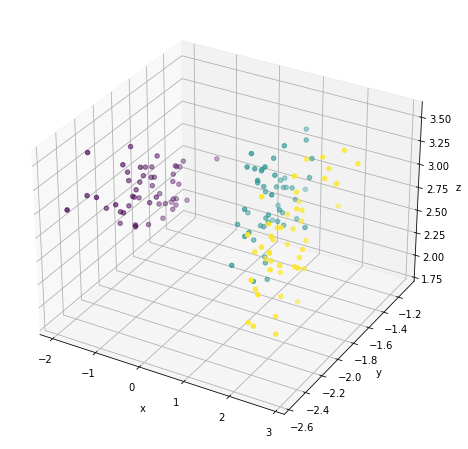

In [13]:
# Vizualize in 3d plot with color of target
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111,projection='3d')
ax.scatter(X_projected[:,0],X_projected[:,1],X_projected[:,2],c=y_iris,cmap='viridis')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()

Shape of X: (150, 4)
Shape of transformed X: (150, 2)


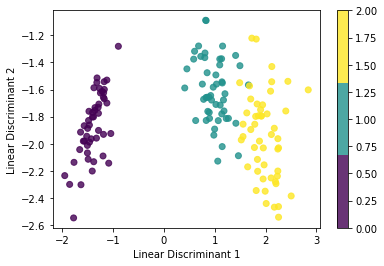

In [14]:
lda = LDA(2)
lda.fit(X_iris,y_iris)
X_projected = lda.transform(X_iris)
print('Shape of X:',X_iris.shape)
print('Shape of transformed X:',X_projected.shape)

x1 = X_projected[:,0]
x2 = X_projected[:,1]

plt.scatter(x1,x2,c = y_iris,alpha = 0.8,
            cmap = plt.cm.get_cmap('viridis',3))
plt.xlabel('Linear Discriminant 1')
plt.ylabel('Linear Discriminant 2')
plt.colorbar()
plt.show()

In [15]:
X

,Temperature,L,R,A_M,Color,Spectral_Class
0,3068,0.002400,0.1700,16.12,0,0
1,3042,0.000500,0.1542,16.60,0,0
2,2600,0.000300,0.1020,18.70,0,0
3,2800,0.000200,0.1600,16.65,0,0
4,1939,0.000138,0.1030,20.06,0,0
...,...,...,...,...,...,...
235,38940,374830.000000,1356.0000,-9.93,6,4
236,30839,834042.000000,1194.0000,-10.63,6,4
237,8829,537493.000000,1423.0000,-10.73,2,2
238,9235,404940.000000,1112.0000,-11.23,2,2


### LDA data and get train, test data

In [16]:
lda = LDA(5)
lda.fit(X.to_numpy(),y)
X = lda.transform(X.to_numpy())
y = y.to_numpy()

In [17]:
# Get test and train data with sklearn
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=123)

### Softmax Regression

In [28]:
import numpy as np
import matplotlib.pyplot as plt

class MultiClassLogisticRegression:

    def __init__(self, n_iter = 10000, thres=0.001,random_state = 4):
        self.n_iter = n_iter
        self.thres = thres
        self.random_state = random_state
    def fit(self, X, y, lr=0.01,verbose=False): 
        np.random.seed(self.random_state)
        self.classes = np.unique(y)
        self.class_labels = {c:i for i,c in enumerate(self.classes)}
        # add bias for each vector
        X = self.add_bias(X)
        y = self.one_hot(y)
        self.loss = []
        self.acc = []
        self.weights = np.random.random((len(self.classes),X.shape[1]))
        self.fit_data(X, y,lr, verbose)
 
    def fit_data(self, X, y,lr, verbose):
        i = 0
        while (i < self.n_iter):
            self.loss.append(self.cross_entropy(y, self.predict_(X)))
            error = y - self.predict_(X)

            self.weights = self.weights+ lr * np.dot(error.T, X)
            if np.abs(lr * np.dot(error.T, X)).max() < self.thres: break 
            self.acc.append(self.evaluate_(X, y))
            if i % 100 == 0 and verbose: 
                print('Training Accuray at {} iterations is {}'.format(i, self.evaluate_(X, y)))
            i +=1
                
    def predict_classes(self, X):
        self.probs_ = self.predict(X)
        return np.vectorize(lambda c: self.classes[c])(np.argmax(self.probs_, axis=1))
    
    def predict(self, X):
        return self.predict_(self.add_bias(X))
    
    def predict_(self, X):
        pre_vals = np.dot(X, self.weights.T).reshape(-1,len(self.classes))
        return self.softmax(pre_vals)
    
    def softmax(self, z):
        return np.exp(z) / np.sum(np.exp(z), axis=1).reshape(-1,1)
    
    def add_bias(self,X):
        return np.insert(X, 0, 1, axis=1)
    
    # One hot encoding
    def one_hot(self, y):
        return np.eye(len(self.classes))[np.vectorize(lambda c: self.class_labels[c])(y).reshape(-1)]
    
    # caculate score
    def score(self, X, y):
        return np.mean(self.predict_classes(X) == y)
    
    # caculate evalute
    def evaluate_(self, X, y):
        return np.mean(np.argmax(self.predict_(X), axis=1) == np.argmax(y, axis=1))
    
    # caculate loss function
    def cross_entropy(self, y, probs):
        return -1 * np.mean(y * np.log(probs))

In [27]:
multi = MultiClassLogisticRegression(n_iter= 2000,random_state=1)
multi.fit(X_train,y_train,lr=0.01,verbose=False)
print('Score: ',multi.score(X_test,y_test))

Score:  1.0


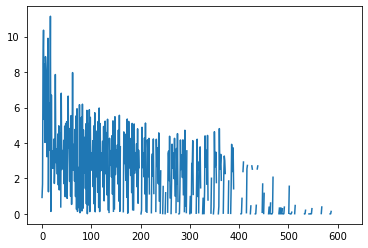

In [20]:
plt.plot(multi.loss)

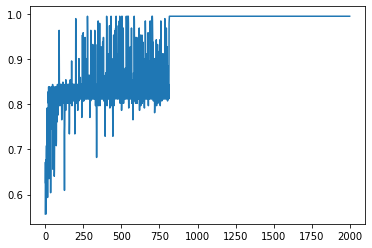

In [21]:
plt.plot(multi.acc)